# Quantitative Analysis of Bitcoin Market Sentiment and Trader Performance

In [1]:
#import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
#setup the directories

BASE_DIR = './'
CSV_DIR = os.path.join(BASE_DIR, 'csv_files')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
print(f"Reading files from: {CSV_DIR}")
print(f"Saving outputs to: {OUTPUT_DIR}")

Reading files from: ./csv_files
Saving outputs to: ./outputs


In [4]:
try:
    # Load Sentiment dataset
    df_sentiment = pd.read_csv(os.path.join(CSV_DIR, 'fear_greed_index.csv'))

    # Load Trades dataset
    df_trades = pd.read_csv(os.path.join(CSV_DIR, 'historical_data.csv'))

    print(f"✓ Data Loaded. Sentiment: {len(df_sentiment)} rows | Trades: {len(df_trades)} rows")

except Exception as e:
    print(f"ERROR: {e}")
    raise

✓ Data Loaded. Sentiment: 2644 rows | Trades: 4659 rows


In [5]:
#clean dates (if there is a typo in that column, now it will not crash and give 'NaT' instead)

df_sentiment['date_clean'] = pd.to_datetime(df_sentiment['date'], errors='coerce')


In [6]:
#force the format of timestamp to be dayfirst then month

df_trades['datetime_obj'] = pd.to_datetime(df_trades['Timestamp IST'], dayfirst=True, errors='coerce')


In [7]:
#we trim the time part of the timestamp from trade dataset so that merging both datasets would be easy

df_trades['date_clean'] = df_trades['datetime_obj'].dt.normalize()

In [8]:
#we convert the numbers that are stored as text to numeric format

df_trades['Closed PnL'] = pd.to_numeric(df_trades['Closed PnL'], errors='coerce').fillna(0)
df_trades['Size USD'] = pd.to_numeric(df_trades['Size USD'], errors='coerce').fillna(0)

In [9]:
#we only want to analyze closed trades where money was actuall made or lost

df_closed = df_trades[df_trades['Closed PnL'] != 0].copy()
print(f"✓ Filtered Data: Analyzing {len(df_closed)} CLOSED trades (removed {len(df_trades) - len(df_closed)} open/zero-pnl trades).")

✓ Filtered Data: Analyzing 1878 CLOSED trades (removed 2781 open/zero-pnl trades).


In [10]:
#we need to mege and keep every single trend

df_merged = pd.merge(df_trades, df_sentiment, on='date_clean', how='left')

In [11]:
# if a trade happened on a day where the "fear and greed index" did not exist or wasnt recorded,
#we cant analyze it so drop them.

df_final = df_merged.dropna(subset=['classification']).copy()
print(f"✓ Match Success: {len(df_final)} trades matched with Sentiment data.")
if len(df_final) < len(df_closed):
    print(f"  (Warning: {len(df_closed) - len(df_final)} trades were dropped because trade dates didn't overlap with sentiment dates)")

✓ Match Success: 687 trades matched with Sentiment data.
  (Warning: 1191 trades were dropped because trade dates didn't overlap with sentiment dates)


In [12]:
#defined a custom order for making the charts more clear

order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
existing_order = [x for x in order if x in df_final['classification'].unique()]

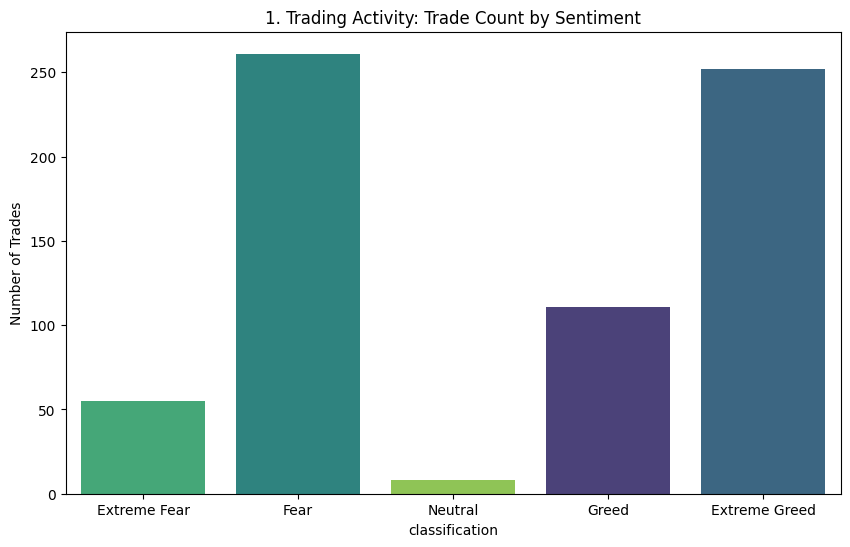

In [13]:
#this counts every time a trade was opened during a specific market mood

plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='classification', hue='classification', order=existing_order, palette='viridis', legend=False)
plt.title('1. Trading Activity: Trade Count by Sentiment')
plt.ylabel('Number of Trades')
plt.savefig(os.path.join(OUTPUT_DIR, '1_activity_levels.png'))
plt.show()

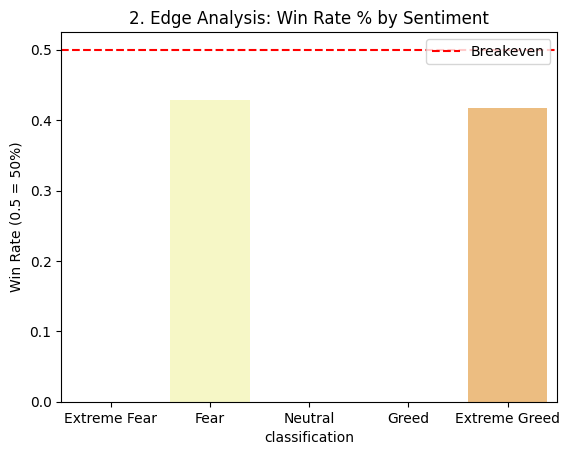

In [14]:
#it looks at the percentage of successful trades (PnL > 0)

df_final['is_win'] = df_final['Closed PnL'] > 0
win_stats = df_final.groupby('classification')['is_win'].mean().reset_index()

sns.barplot(data=win_stats, x='classification', y='is_win', hue='classification', order=existing_order, palette='RdYlGn', legend=False)
plt.axhline(0.5, color='red', linestyle='--', label='Breakeven')
plt.title('2. Edge Analysis: Win Rate % by Sentiment')
plt.ylabel('Win Rate (0.5 = 50%)')
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, '2_win_rate.png'))
plt.show()

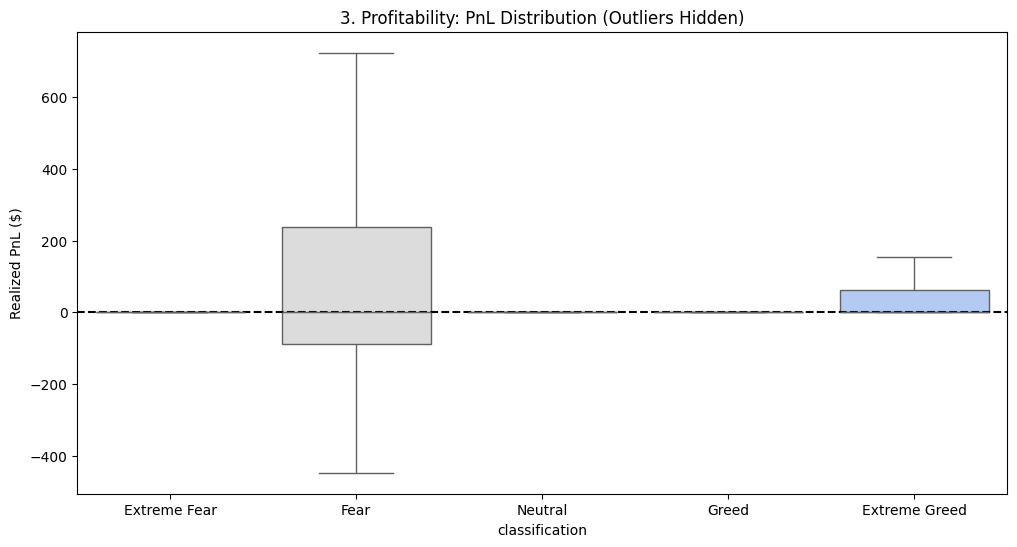

In [15]:
#shows the "range" of money made or lost

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final, x='classification', y='Closed PnL', hue='classification', order=existing_order, palette='coolwarm', showfliers=False, legend=False)
plt.axhline(0, color='black', linestyle='--')
plt.title('3. Profitability: PnL Distribution (Outliers Hidden)')
plt.ylabel('Realized PnL ($)')
plt.savefig(os.path.join(OUTPUT_DIR, '3_pnl_distribution.png'))
plt.show()

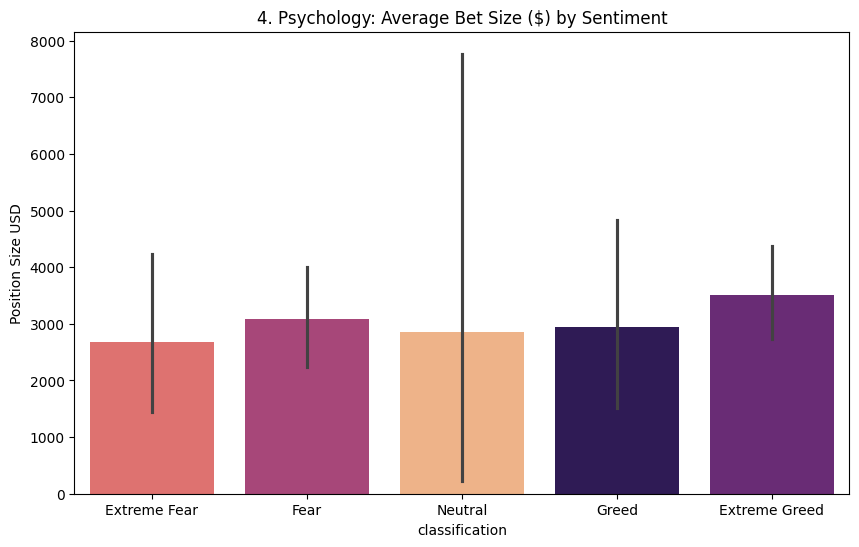

In [16]:
#This calculates the average USD value (Size) of each position.

plt.figure(figsize=(10, 6))
sns.barplot(data=df_final, x='classification', y='Size USD', hue='classification', order=existing_order, palette='magma', legend=False)
plt.title('4. Psychology: Average Bet Size ($) by Sentiment')
plt.ylabel('Position Size USD')
plt.savefig(os.path.join(OUTPUT_DIR, '4_risk_appetite.png'))
plt.show()

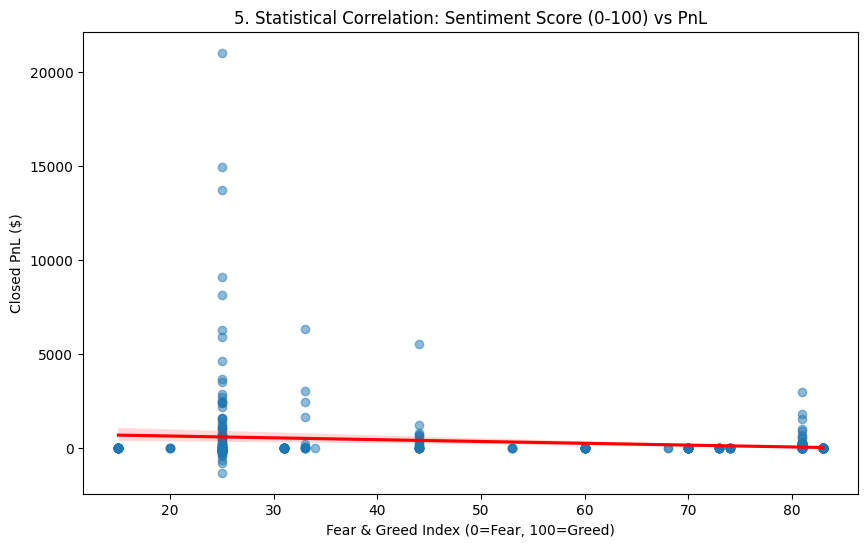

In [17]:
plt.figure(figsize=(10, 6))
plot_data = df_final.sample(n=min(500, len(df_final)), random_state=42)
sns.regplot(data=plot_data, x='value', y='Closed PnL', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('5. Statistical Correlation: Sentiment Score (0-100) vs PnL')
plt.xlabel('Fear & Greed Index (0=Fear, 100=Greed)')
plt.ylabel('Closed PnL ($)')
plt.savefig(os.path.join(OUTPUT_DIR, '5_correlation_scatter.png'))
plt.show()

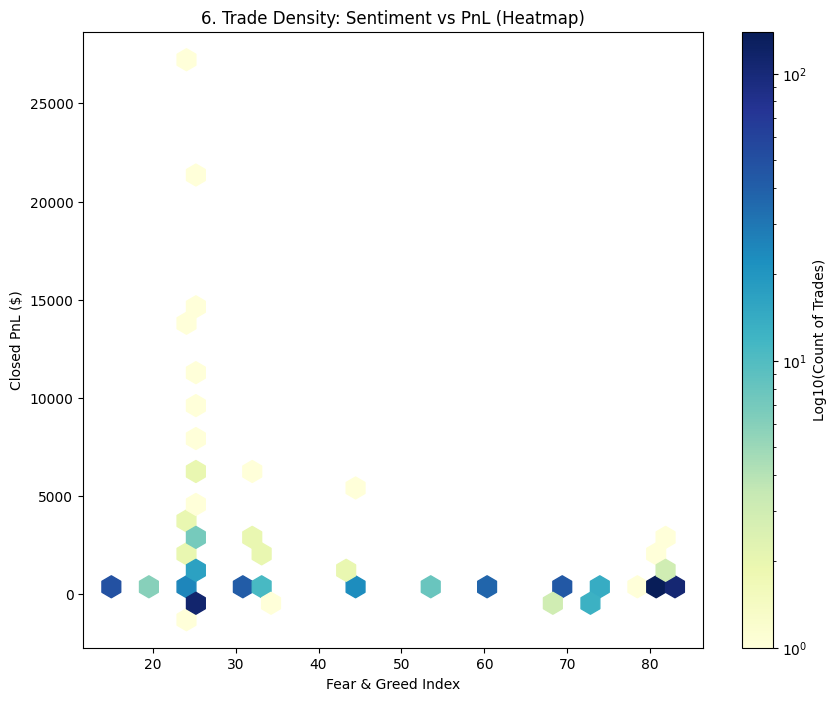

In [18]:
plt.figure(figsize=(10, 8))
plt.hexbin(df_final['value'], df_final['Closed PnL'], gridsize=30, cmap='YlGnBu', bins='log')
plt.colorbar(label='Log10(Count of Trades)')
plt.title('6. Trade Density: Sentiment vs PnL (Heatmap)')
plt.xlabel('Fear & Greed Index')
plt.ylabel('Closed PnL ($)')
plt.savefig(os.path.join(OUTPUT_DIR, '6_density_hexbin.png'))
plt.show()